# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [79]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

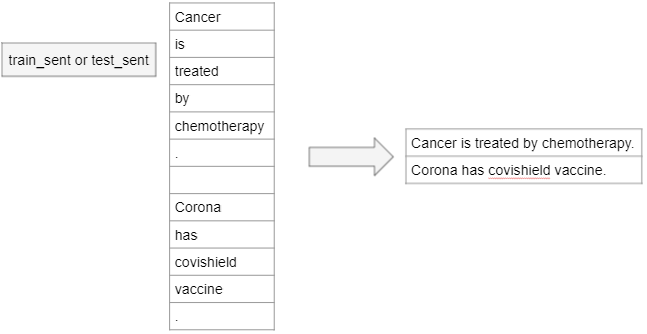

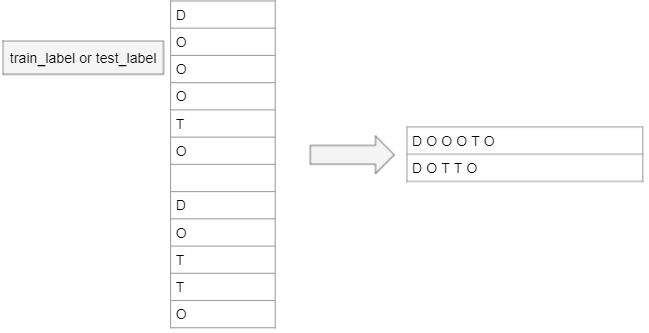

In [80]:
with open('train_sent', 'r') as train_sent_file:
  train_sentences = train_sent_file.readlines()

with open('train_label', 'r') as train_label_file:
  train_labels = train_label_file.readlines()

with open('test_sent', 'r') as test_sent_file:
  test_sentences = test_sent_file.readlines()

with open('test_label', 'r') as test_label_file:
  test_labels = test_label_file.readlines()


In [81]:
train_sentence_array = []
train_sentence = []
for token in train_sentences:
    if token != "\n":
        train_sentence.append(token[:-1])
    else:
        new_sent = " ".join(train_sentence)
        train_sentence_array.append(new_sent)
        train_sentence.clear()

train_label_sentence_array = []
train_label_sentence = []
for token in train_labels:
    if token != "\n":
        train_label_sentence.append(token[:-1])
    else:
        new_label = " ".join(train_label_sentence)
        train_label_sentence_array.append(new_label)
        train_label_sentence.clear()

for i in range(0,5):
    print(train_sentence_array[i])
    print('\n')
    print(train_label_sentence_array[i])
    print('\n')    

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


O O O O O O O O O O O O O O O O O O O O O O O O O


Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )


O O O O O O O O O O O O O O O


The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )


O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )


O O O O O O O O O O 

In [82]:
test_sentence_array = []
test_sentence = []
for token in test_sentences:
    if token != "\n":
        test_sentence.append(token[:-1])
    else:
        new_sent = " ".join(test_sentence)
        test_sentence_array.append(new_sent)
        test_sentence.clear()

test_label_sentence_array = []
test_label_sentence = []
for token in test_labels:
    if token != "\n":
        test_label_sentence.append(token[:-1])
    else:
        new_label = " ".join(test_label_sentence)
        test_label_sentence_array.append(new_label)
        test_label_sentence.clear()


for i in range(0,5):
    print(test_sentence_array[i])
    print('\n')
    print(test_label_sentence_array[i])
    print('\n') 

Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )


O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration


O O O O O O O O O O O O O O O O O O O


The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period


O O O O O O O O O O O O O O O O O O O O O O O O


There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )


O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


Fluctuations in ambient temperature are inversely correlated to changes in AFI


O O O O O O O O O O O




### Count the number of sentences in the processed train and test dataset 

In [83]:
print("Number of sentences in train dataset:",len(train_sentence_array))
print("Number of sentences in test dataset:",len(test_sentence_array))

Number of sentences in train dataset: 2599
Number of sentences in test dataset: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [84]:
print("Number of lines of labels in train dataset:",len(train_label_sentence_array))
print("Number of lines of labels in test dataset:",len(test_label_sentence_array))

Number of lines of labels in train dataset: 2599
Number of lines of labels in test dataset: 1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [85]:
new_sentence_array = train_sentence_array + test_sentence_array
token_freq_dict = {}
for train_sentence in new_sentence_array:
    tokens = model(train_sentence)
    for tok in tokens:
        if tok.pos_ == "NOUN" or tok.pos_ == "PROPN":
            if tok.text in token_freq_dict:
                freq = int(token_freq_dict[tok.text])
                token_freq_dict[tok.text] = freq + 1
            else:
                token_freq_dict[tok.text] = 1                

print(token_freq_dict)

{'births': 2, '=': 44, 'weeks': 37, 'University': 6, 'Vermont': 1, 'delivery': 21, 'route': 2, 'indication': 5, 'age': 56, 'parity': 4, 'practice': 31, 'group': 94, 'risk': 71, 'status': 17, 'rate': 67, '%': 247, 'presentation': 7, 'medicine': 36, 'patients': 492, 'Arrest': 1, 'dilation': 4, 'subgroups': 4, 'rates': 34, 'care': 56, 'hospitals': 10, 'community': 15, 'groups': 34, 'trimester': 4, 'fluid': 8, 'index': 13, 'AFI': 6, 'temperature': 10, 'increases': 6, 'decrease': 5, 'June': 2, 'August': 6, 'period': 28, 'heat': 5, 'women': 77, 'singleton': 1, 'pregnancies': 7, 'gestation': 4, 'testing': 25, 'determinations': 2, 'area': 11, 'day': 36, 'test': 20, 'date': 3, 'Spearman': 1, 'rank': 2, 'Correlation': 3, 'relationship': 12, 'account': 4, 'measure': 4, 'being': 2, 'study': 153, 'population': 31, 'diabetes': 31, 'screening': 16, 'clinic': 5, 'Hadassah': 1, 'Medical': 6, 'Center': 3, 'year': 46, 'treatment': 281, 'week': 11, 'protocol': 6, 'control': 51, 'characteristics': 18, 'dif

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [86]:
sorted_items = sorted(token_freq_dict.items(), key=lambda item: item[1], reverse=True)
for i in range(0,25):
    print(sorted_items[i])

('patients', 492)
('treatment', 281)
('%', 247)
('cancer', 200)
('therapy', 175)
('study', 153)
('disease', 141)
('cell', 140)
('lung', 116)
('group', 94)
('chemotherapy', 88)
('gene', 87)
('effects', 85)
('women', 77)
('results', 77)
('use', 73)
('risk', 71)
('cases', 71)
('surgery', 71)
('analysis', 70)
('rate', 67)
('response', 66)
('survival', 65)
('children', 64)
('effect', 63)


## Defining features for CRF





In [88]:
# Let's define the features to get the feature value for one word.
def getFeaturesForWord(sentence, pos):
    word = sentence[pos]
    
    features = [
        'word.lower=' + word.lower(),   # servers as word id
        'word[-3:]=' + word[-3:],   # last three characters
        'word[-2:]=' + word[-2:],   # last two characters
        'word[-1:]=' + word[-1:],   # last three characters
        'word[:0]=' + word[:0],     # first one characters
        'word[:1]=' + word[:1],     # first two characters
        'word[:2]=' + word[:2],     # first three characters        
        'word.isupper=%s' % word.isupper(),    # is the word in all uppercase
        'word.isdigit=%s' % word.isdigit(),    # is the word a number
        'word.startsWithCapital=%s' % word[0].isupper()   # is the word starting with a capital
    ]
    
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
            'prev_word.lower=' + prev_word.lower(),
            'prev_word[-3:]=' + prev_word[-3:],   # last three characters
            'prev_word[-2:]=' + prev_word[-2:],   # last two characters
            'prev_word[-1:]=' + prev_word[-1:],   # last three characters
            'prev_word[:0]=' + prev_word[:0],     # first one characters
            'prev_word[:1]=' + prev_word[:1],     # first two characters
            'prev_word[:2]=' + prev_word[:2],     # first three characters   
            'prev_word.isupper=%s' % prev_word.isupper(),            
            'prev_word.isdigit=%s' % prev_word.isdigit(),
            'prev_word.startWithCapital=%s' % prev_word[0].isupper(),           
        ])
    elif((pos < len(sentence)-1) and (pos != 0)):
        next_word = sentence[pos+1]
        features.extend([
            'next_word.lower=' + next_word.lower(),
            'next_word[-3:]=' + next_word[-3:],   # last three characters
            'next_word[-2:]=' + next_word[-2:],   # last two characters
            'next_word[-1:]=' + next_word[-1:],   # last three characters
            'next_word[:0]=' + next_word[:0],     # first one characters
            'next_word[:1]=' + next_word[:1],     # first two characters
            'next_word[:2]=' + next_word[:2],     # first three characters   
            'next_word.isupper=%s' % next_word.isupper(),            
            'next_word.isdigit=%s' % next_word.isdigit(),
            'next_word.startWithCapital=%s' % next_word[0].isupper(),           
        ])
    else:
        features.append('BEG') # feature to track begin of sentence
        
    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence
        
    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [89]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    sentence_list = sentence.split()
    return [getFeaturesForWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [90]:
# Write a code to get the labels for a sentence.
def getLabelsForOneSentence(labels):
    return labels.split()

In [91]:
example_sentence = train_sentence_array[5]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
print(features)

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age
[['word.lower=cesarean', 'word[-3:]=ean', 'word[-2:]=an', 'word[-1:]=n', 'word[:0]=', 'word[:1]=C', 'word[:2]=Ce', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=True', 'BEG'], ['word.lower=rates', 'word[-3:]=tes', 'word[-2:]=es', 'word[-1:]=s', 'word[:0]=', 'word[:1]=r', 'word[:2]=ra', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'prev_word.lower=cesarean', 'prev_word[-3:]=ean', 'prev_word[-2:]=an', 'prev_word[-1:]=n', 'prev_word[:0]=', 'prev_word[:1]=C', 'prev_word[:2]=Ce', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startWithCapital=True'], ['word.lower=at', 'word[-3:]=at', 'word[-2:]=at', 'word[-1:]=t', 'word[:0]=', 'word[:1]=a', 'word[:2]=at', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'prev_word.lower=rates', 'pr

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [92]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentence_array]


X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentence_array]


### Define the labels as the target variable for test and the train dataset

In [93]:
Y_train = [getLabelsForOneSentence(labels) for labels in train_label_sentence_array]
Y_test = [getLabelsForOneSentence(labels) for labels in test_label_sentence_array]

## Build the CRF Model

In [94]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [96]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [97]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9105027684429905

In [99]:
for i in range(len(test_sentence_array)):
    print("Sentence:", test_sentence_array[i])
    print("Orig Labels:", Y_test[i])
    print("Pred Labels:", Y_pred[i])

Sentence: Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Sentence: As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



In [134]:
import pandas as pd
desease_treatment_dict = {}
for i in range(len(test_sentence_array)):
    test_sentence = test_sentence_array[i].split()
    label_sentence = Y_pred[i] 
    key = []
    value = []
    for token, label in zip(test_sentence, label_sentence):
        if label == 'D':
            key.append(token)
        elif label == 'T':
            value.append(token)
            
    if len(key) > 0 and len(value) > 0:
        desease = " ".join(key)
        treatments = " ".join(value)
        if desease in desease_treatment_dict.keys():
            values = desease_treatment_dict[desease]
            if treatments not in values:
                desease_treatment_dict[desease] = treatments
        else :
            desease_treatment_dict[desease] = treatments            

### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

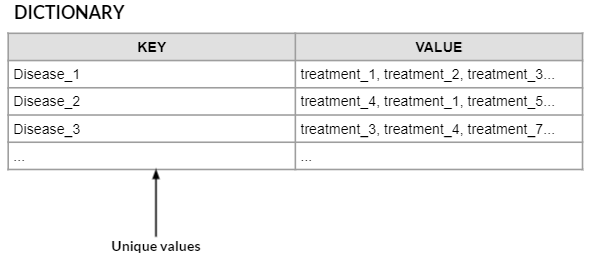

In [135]:
desease_treatment = pd.DataFrame({'KEY' : desease_treatment_dict.keys() , 'VALUE' : desease_treatment_dict.values() })

desease_treatment

,KEY,VALUE
0,macrosomic infants gestational diabetes cases,good glycemic control
1,nonimmune hydrops fetalis,Trisomy
2,hereditary retinoblastoma,radiotherapy
3,myocardial infarction,"aspirin aspirin , or 1 mg warfarin aspirin"
4,unstable angina or non-Q-wave myocardial infar...,roxithromycin
...,...,...
113,severe secondary peritonitis,Surgical management
114,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy
115,chronic renal failure,Epoetin
116,epithelial ovarian cancer,High-dose chemotherapy


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [136]:
print('Treatment for the disease name: "hereditary retinoblastoma" is: ',desease_treatment_dict['hereditary retinoblastoma'])

Treatment for the disease name: "hereditary retinoblastoma" is:  radiotherapy
